In [12]:
import os
import glob
import torch
import torch.utils.data
import datetime
import numpy as np
import pandas as pd
from dateutil import parser
from functools import reduce
import matplotlib.pyplot as plt
from alive_progress import alive_bar

In [13]:
# loading daily& hourly data, and get the user's id who appear in both data
fs = ('daily', 'hourly')
root = os.path.join(os.getcwd(), "out\\")
csv_files = {os.path.basename(p) : glob.glob(os.path.join(p, "*.csv")) for p, _, files in os.walk(root) if len(files) > 0 and os.path.basename(p) in fs}
datasets = {folder:{int(os.path.splitext(os.path.basename(f))[0]): pd.read_csv(f) for f in fs} for folder, fs in csv_files.items()}
ids = list(reduce(set.intersection, [set(dataset.keys()) for dataset in datasets.values()]))

In [14]:
# calculate SleepEffecent
for id in ids:
    df = datasets['daily'][id]
    df['SleepEffecent'] = df['TotalMinutesAsleep'] / df['TotalTimeInBed']
    datasets['daily'][id] = df.drop(columns=['Unnamed: 0', 'TotalMinutesAsleep', 'TotalTimeInBed', 'TotalSleepRecords'])
datasets['daily'][ids[0]].keys()

Index(['date', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance_x',
       'ModeratelyActiveDistance_x', 'LightActiveDistance_x',
       'SedentaryActiveDistance_x', 'VeryActiveMinutes_x',
       'FairlyActiveMinutes_x', 'LightlyActiveMinutes_x', 'SedentaryMinutes_x',
       'Calories_x', 'Calories_y', 'SedentaryMinutes_y',
       'LightlyActiveMinutes_y', 'FairlyActiveMinutes_y',
       'VeryActiveMinutes_y', 'SedentaryActiveDistance_y',
       'LightActiveDistance_y', 'ModeratelyActiveDistance_y',
       'VeryActiveDistance_y', 'StepTotal', 'SleepEffecent'],
      dtype='object')

In [15]:
# usuful keys of daily data (ignore 'date' and other meaningless keys)
daily_keys = ['TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance_x',
       'ModeratelyActiveDistance_x', 'LightActiveDistance_x',
       'SedentaryActiveDistance_x', 'VeryActiveMinutes_x',
       'FairlyActiveMinutes_x', 'LightlyActiveMinutes_x', 'SedentaryMinutes_x',
       'Calories_x', 'Calories_y', 'SedentaryMinutes_y',
       'LightlyActiveMinutes_y', 'FairlyActiveMinutes_y',
       'VeryActiveMinutes_y', 'SedentaryActiveDistance_y',
       'LightActiveDistance_y', 'ModeratelyActiveDistance_y',
       'VeryActiveDistance_y', 'StepTotal'
       ]

Notice that same data for different user has different meaning. For example, 3000 step per day has different meaning for the user who make 1000 step per day and the user who make more than 5000 step per day. Therefore, we use the `mean` and `std` of a user as his context. Which means, the model is build base on the z-sorce of different user.

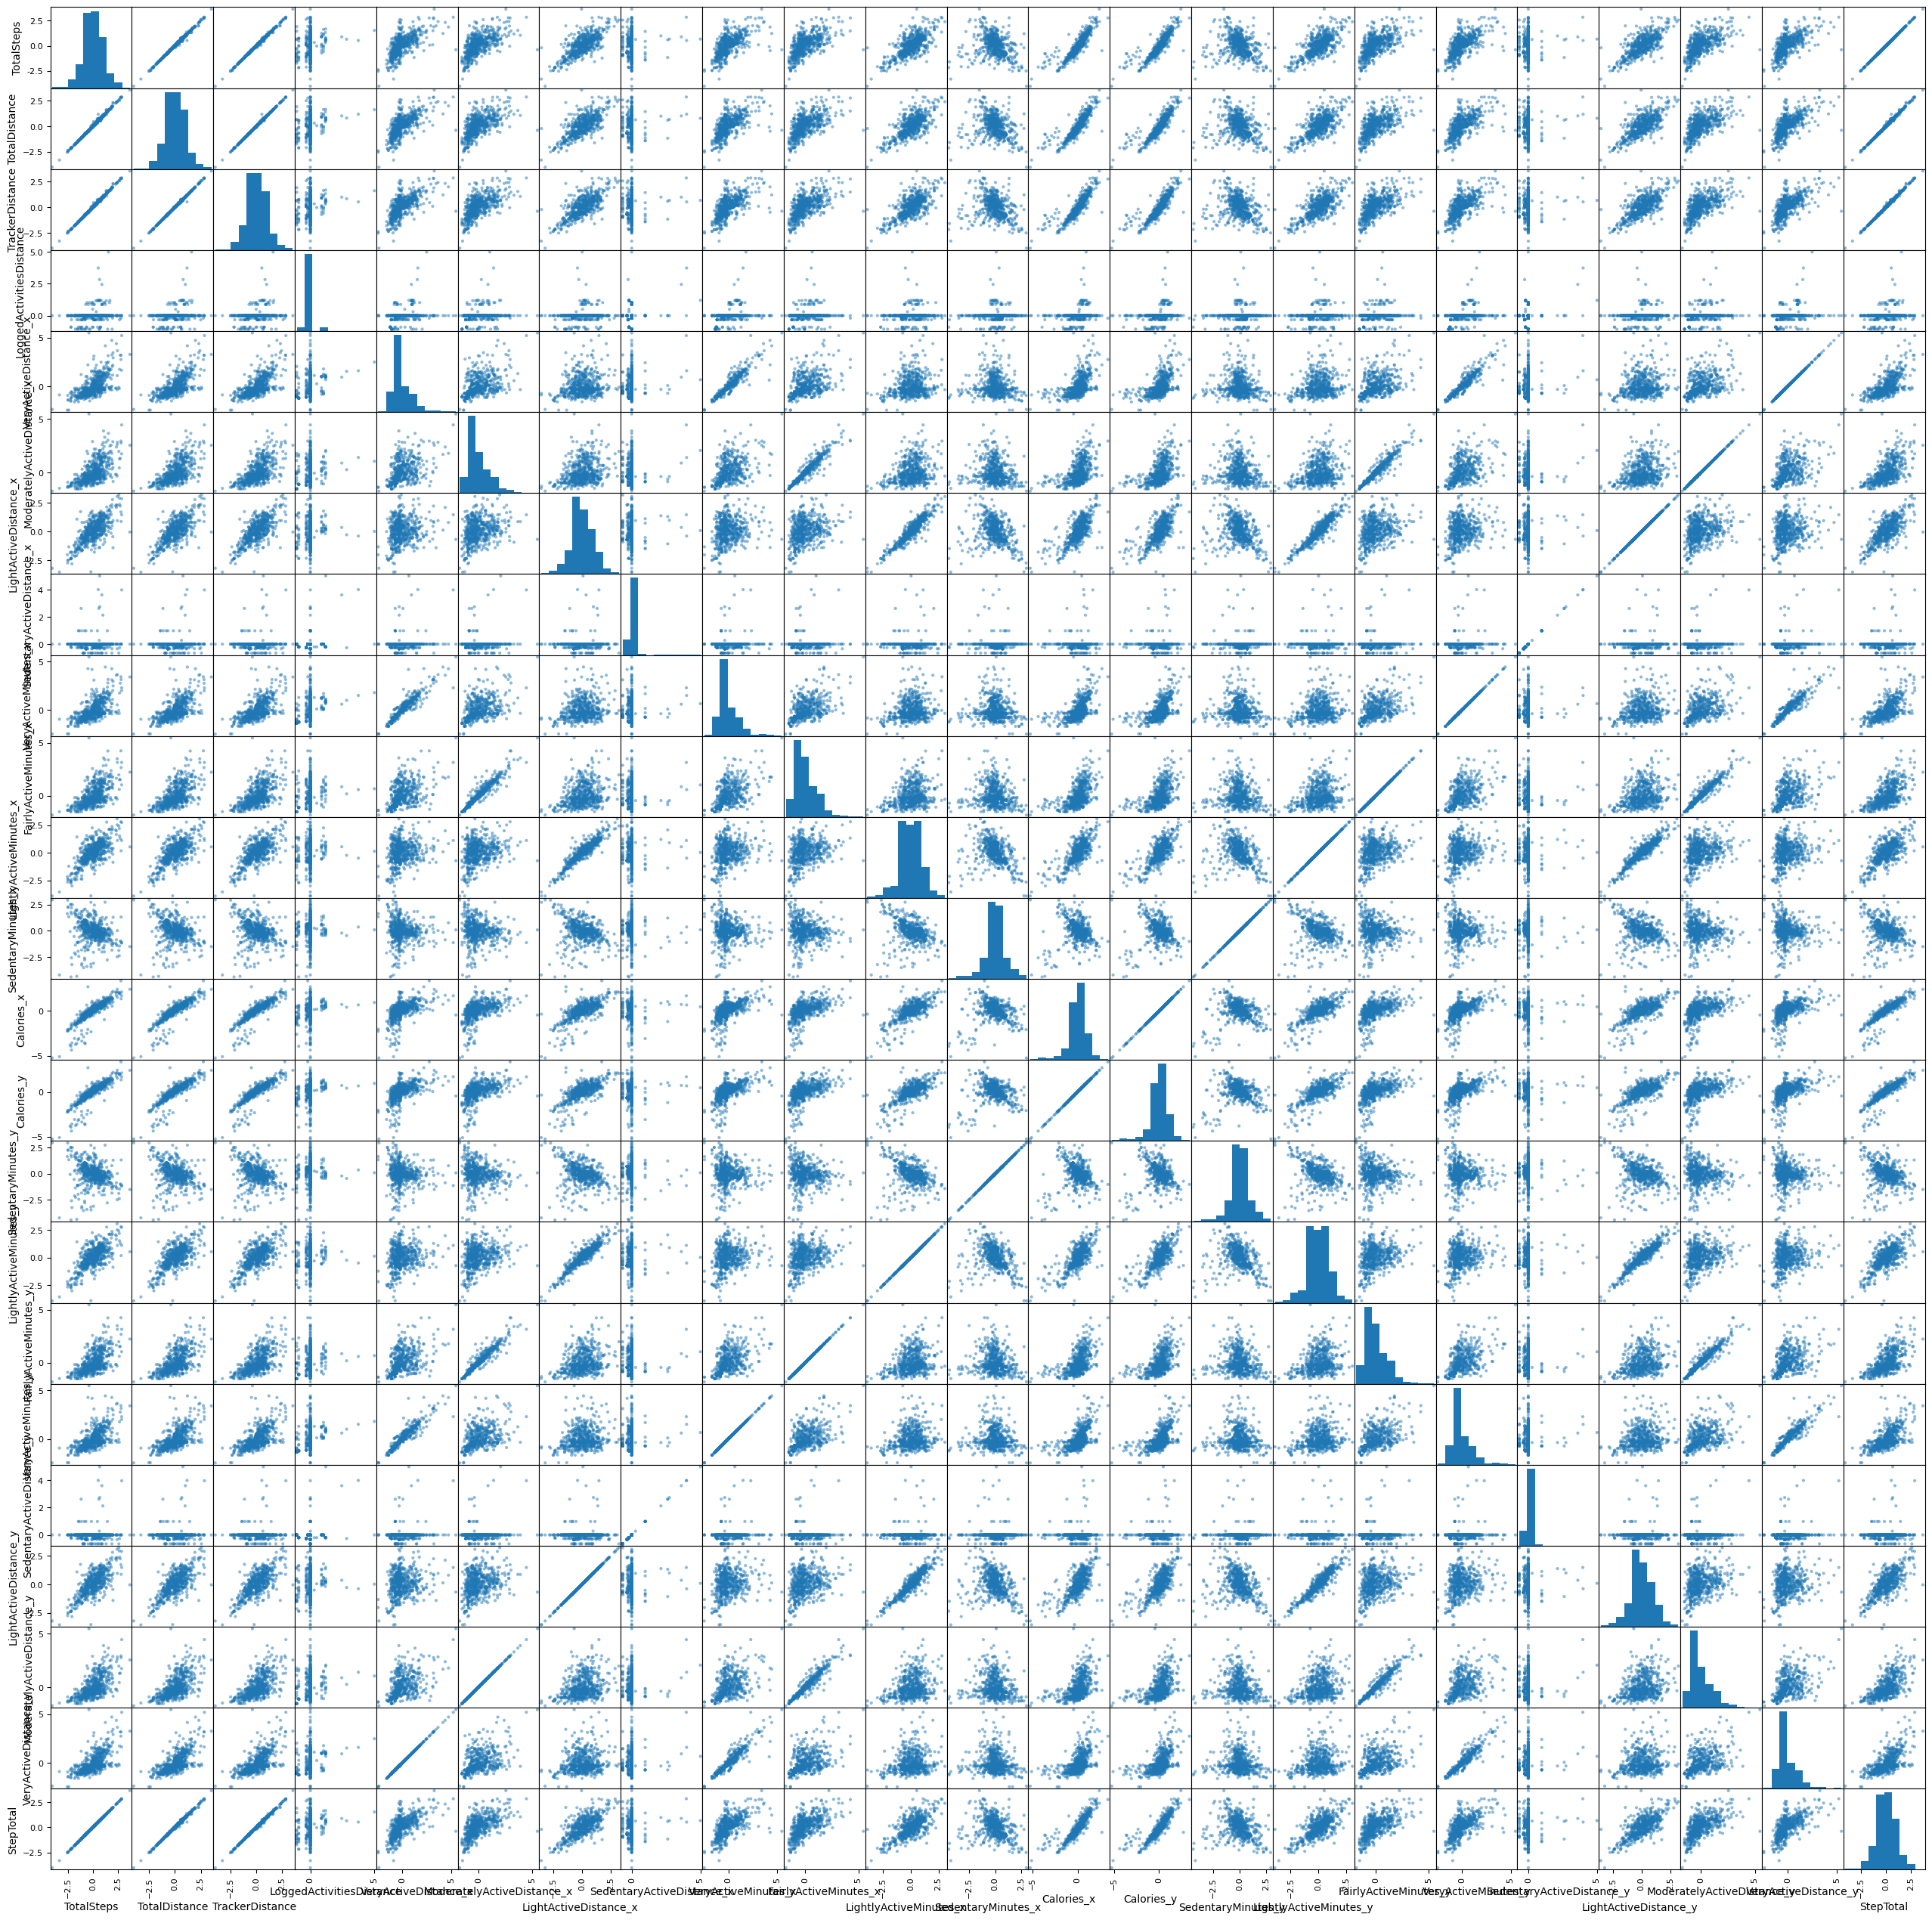

In [33]:
# seprate the data, and apply user's context (the mean&std of one user is his context)

train_ids = ids[:-3]
test_ids = ids[-3:]

def z_score(x):
    mean = np.nanmean(x, axis=0)
    std = np.nan_to_num(np.nanstd(x, axis=0), nan=1.0)
    std[std==0] = 1.0
    return (x - mean) / std

def get_ids_dataset(ids, X_keys, y_key):
    X, y = None, None
    for id in ids:
        X_cols, y_col = datasets['daily'][id][X_keys].values, datasets['daily'][id][y_key].values
        if len(y_col.shape) < 2:
            y_col = y_col[:, None]

        X_cols = z_score(X_cols)
        #y_col = z_score(y_col)

        X = X_cols if X is None else np.concatenate([X, X_cols], axis=0, dtype=np.float64)
        y = y_col if y is None else np.concatenate([y, y_col], axis=0)

    return X, y

train_X, train_y = get_ids_dataset(train_ids, daily_keys, 'SleepEffecent')
test_X, test_y = get_ids_dataset(test_ids, daily_keys, 'SleepEffecent')

assert train_X is not None and train_y is not None
assert test_X is not None and test_y is not None

pd.plotting.scatter_matrix(pd.DataFrame(train_X[np.isfinite(train_X).all(axis=-1)], columns=daily_keys), figsize=(32, 32))
pass

Noitce, there are many linear relationship between features. Thus we using an AutoEncoder to reduce dimensions.

In [17]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, features:int, coded:int=6, hidden:int=12) -> None:
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(features, hidden), torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden), torch.nn.ReLU(),
            torch.nn.Linear(hidden, coded)
        )

        self.decoders = torch.nn.Sequential(
            torch.nn.Linear(coded, hidden), torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden), torch.nn.ReLU(),
            torch.nn.Linear(hidden, features)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoders(x)
        return x

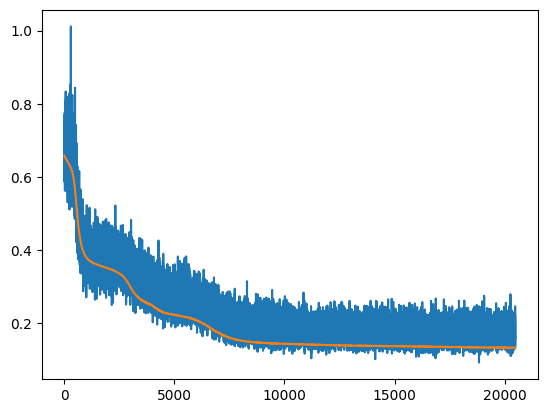

In [18]:
assert train_X is not None and train_y is not None
assert test_X is not None and test_y is not None

ae = AutoEncoder(train_X.shape[-1], 5, 16)
optim = torch.optim.AdamW(ae.parameters(), lr=1e-4, weight_decay=1e-2, amsgrad=True)
criterion = torch.nn.L1Loss()

train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(train_X[np.isfinite(train_X).all(axis=-1)]).float()), shuffle=True, batch_size=32)
test_dataset = torch.as_tensor(test_X[np.isfinite(test_X).all(axis=-1)]).float()


train_losses = []
test_losses = []
epoch_cnt = 1024
with alive_bar(epoch_cnt, force_tty=True, receipt=False, refresh_secs=1/10, calibrate=50, spinner='classic') as bar:
    for epoch in range(epoch_cnt):
        loss = torch.tensor(0)
        for batch, [ys, ] in enumerate(train_dataloader):
            ae.train()

            optim.zero_grad()
            loss = criterion(ae(ys), ys)
            loss.backward()
            optim.step()

            train_losses.append(loss.item())

            with torch.no_grad():
                ae.eval()
                test_losses.append(criterion(ae(test_dataset), test_dataset).item())

        bar()

plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

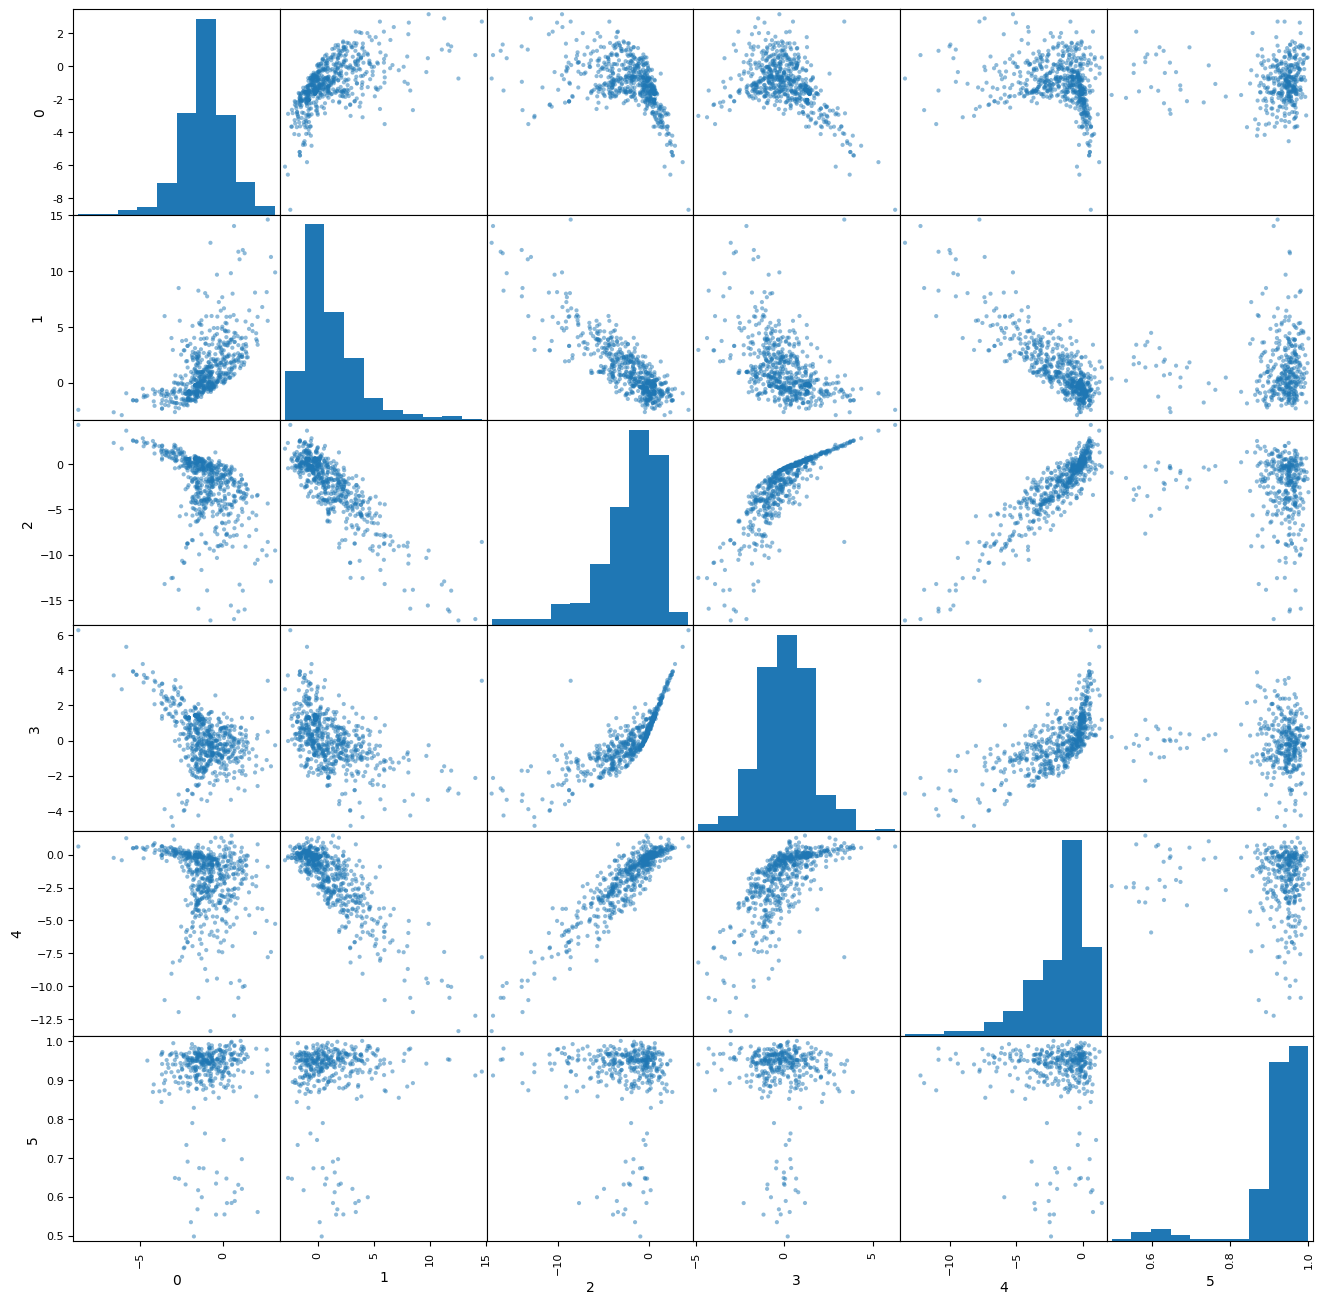

In [19]:
assert train_X is not None and train_y is not None
assert test_X is not None and test_y is not None
pd.plotting.scatter_matrix(pd.DataFrame(np.concatenate([ae.encoder(torch.from_numpy(train_X[np.isfinite(train_X).all(axis=-1)]).float()).numpy(force=True), train_y], axis=-1)), figsize=(16, 16))
pass

The `feature 0` - `feature 4` is the features after dimension reducing, and the `feature 5` is the sleep efficent.

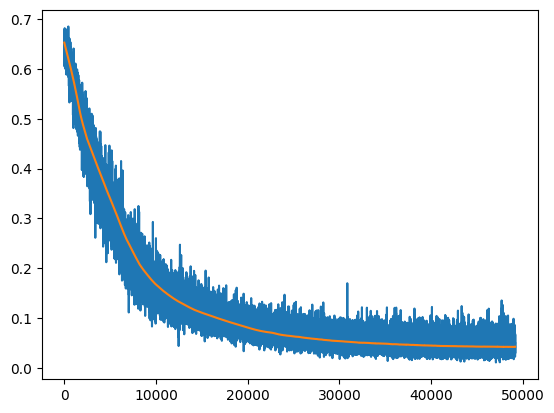

In [31]:
# using a DNN to predict sleep effcient
assert train_X is not None and train_y is not None
assert test_X is not None and test_y is not None

pred_model = torch.nn.Sequential(
    torch.nn.Linear(5, 8), torch.nn.ReLU(),
    torch.nn.Linear(8, 16), torch.nn.ReLU(),
    torch.nn.Linear(16, 8), torch.nn.ReLU(),
    torch.nn.Linear(8, 1)
)
optim = torch.optim.AdamW(pred_model.parameters(), lr=1e-5, weight_decay=1e-2, amsgrad=True)
criterion = torch.nn.L1Loss()

train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(train_X[np.isfinite(train_X).all(axis=-1) & np.isfinite(train_y).all(axis=-1)]).float(),
        torch.from_numpy(train_y[np.isfinite(train_X).all(axis=-1) & np.isfinite(train_y).all(axis=-1)]).float(),
    ), shuffle=True, batch_size=32)
torch_test_X = torch.as_tensor(test_X[np.isfinite(test_X).all(axis=-1) & np.isfinite(test_y).all(axis=-1)]).float()
torch_test_y = torch.as_tensor(test_y[np.isfinite(test_X).all(axis=-1) & np.isfinite(test_y).all(axis=-1)]).float()

train_losses = []
test_losses = []
epoch_cnt = 4096
with alive_bar(epoch_cnt, force_tty=True, receipt=False, refresh_secs=1/10, calibrate=50, spinner='classic') as bar:
    for epoch in range(epoch_cnt):
        loss = torch.tensor(0)
        for batch, [Xs, ys] in enumerate(train_dataloader):
            with torch.no_grad():
                ae.eval()
                Xs = ae.encoder(Xs)
            
            pred_model.train()
            optim.zero_grad()
            loss = criterion(pred_model(Xs), ys)
            loss.backward()
            optim.step()

            train_losses.append(loss.item())

            with torch.no_grad():
                ae.eval()
                pred_model.eval()
                test_losses.append(criterion(pred_model(ae.encoder(torch_test_X)), torch_test_y).item())

        bar()

plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

Base on the current state of the user, we can perdict his sleeping efficent using the `DNN`. Then, using `torch.autograd.grad` to get the best way to improve the sleeping efficent

In [35]:
for x, _ in zip(torch_test_X, range(5)):
    x.requires_grad = True
    y = pred_model(ae.encoder(x))

    g, = torch.autograd.grad(y, x)

    for i, _ in zip(torch.argsort(torch.abs(g)), range(10)):
        print(f'{"↑" if g[i] > 0 else "↓"} {daily_keys[i]}')
    print('\n\n')

↑ LoggedActivitiesDistance
↑ SedentaryMinutes_x
↓ SedentaryActiveDistance_y
↑ Calories_y
↑ SedentaryMinutes_y
↑ SedentaryActiveDistance_x
↓ VeryActiveMinutes_x
↓ LightActiveDistance_x
↑ FairlyActiveMinutes_y
↓ LightlyActiveMinutes_y



↑ LoggedActivitiesDistance
↑ SedentaryMinutes_x
↓ SedentaryActiveDistance_y
↑ Calories_y
↑ SedentaryMinutes_y
↑ SedentaryActiveDistance_x
↓ VeryActiveMinutes_x
↓ LightActiveDistance_x
↑ FairlyActiveMinutes_y
↓ LightlyActiveMinutes_y



↓ LightActiveDistance_y
↑ Calories_y
↑ LoggedActivitiesDistance
↓ TrackerDistance
↑ FairlyActiveMinutes_x
↓ Calories_x
↑ SedentaryActiveDistance_y
↓ FairlyActiveMinutes_y
↑ ModeratelyActiveDistance_x
↓ TotalSteps



↑ VeryActiveDistance_x
↓ VeryActiveDistance_y
↑ VeryActiveMinutes_x
↓ SedentaryActiveDistance_y
↑ SedentaryMinutes_y
↑ LoggedActivitiesDistance
↑ VeryActiveMinutes_y
↑ SedentaryMinutes_x
↓ SedentaryActiveDistance_x
↓ FairlyActiveMinutes_y



↓ LightActiveDistance_y
↑ Calories_y
↑ LoggedActivitiesDistance
↓ Trac

In [26]:
datasets['daily'][test_ids[0]]

date  TotalSteps  TotalDistance  TrackerDistance  \
0   2016-04-12 00:00:00        3276           2.20             2.20   
1   2016-04-13 00:00:00        2961           1.99             1.99   
2   2016-04-14 00:00:00        3974           2.67             2.67   
3   2016-04-15 00:00:00        7198           4.83             4.83   
4   2016-04-16 00:00:00        3945           2.65             2.65   
5   2016-04-17 00:00:00        2268           1.52             1.52   
6   2016-04-18 00:00:00        6155           4.24             4.24   
7   2016-04-19 00:00:00        2064           1.39             1.39   
8   2016-04-20 00:00:00        2072           1.39             1.39   
9   2016-04-21 00:00:00        3809           2.56             2.56   
10  2016-04-22 00:00:00        6831           4.58             4.58   
11  2016-04-23 00:00:00        4363           2.93             2.93   
12  2016-04-24 00:00:00        5002           3.36             3.36   
13  2016-04-25 00:00:00        3385           2.27             2.27   
14  2016-04-26 00:00:00        6326           4.41             4.41   
15  2016-04-27 00:00:00        7243           5.03             5.03   
16  2016-04-28 00:00:00        4493           3.01             3.01   
17  2016-04-29 00:00:00        4676           3.14             3.14   
18  2016-04-30 00:00:00        6222           4.18             4.18   
19  2016-05-01 00:00:00        5232           3.51             3.51   
20  2016-05-02 00:00:00        6910           4.75             4.75   
21  2016-05-03 00:00:00        7502           5.18             5.18   
22  2016-05-04 00:00:00        2923           1.96             1.96   
23  2016-05-05 00:00:00        3800           2.55             2.55   
24  2016-05-06 00:00:00        4514           3.03             3.03   
25  2016-05-07 00:00:00        5183           3.59             3.59   
26  2016-05-08 00:00:00        7303           4.90             4.90   
27  2016-05-09 00:00:00        5275           3.54             3.54   
28  2016-05-10 00:00:00        3915           2.63             2.63   
29  2016-05-11 00:00:00        9105           6.11             6.11   
30  2016-05-12 00:00:00         768           0.52             0.52   

    LoggedActivitiesDistance  VeryActiveDistance_x  \
0                        0.0                  0.00   
1                        0.0                  0.00   
2                        0.0                  0.00   
3                        0.0                  0.00   
4                        0.0                  0.00   
5                        0.0                  0.00   
6                        0.0                  2.00   
7                        0.0                  0.00   
8                        0.0                  0.00   
9                        0.0                  0.00   
10                       0.0                  0.00   
11                       0.0                  0.00   
12                       0.0                  0.00   
13                       0.0                  0.00   
14                       0.0                  2.41   
15                       0.0                  2.62   
16                       0.0                  0.00   
17                       0.0                  0.00   
18                       0.0                  0.00   
19                       0.0                  0.00   
20                       0.0                  2.21   
21                       0.0                  2.48   
22                       0.0                  0.00   
23                       0.0                  0.12   
24                       0.0                  0.00   
25                       0.0                  2.13   
26                       0.0                  0.00   
27                       0.0                  0.00   
28                       0.0                  0.00   
29                       0.0                  2.25   
30                       0.0                  0.00   

    ModeratelyAct